Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Oleg Bushtyrkov | k12338089 | 17.06.2024, 09:30

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 – Language Modeling with LSTM (Assignment)</h2>

<b>Authors:</b> N. Rekabsaz, B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, M. Abbass, A. Schörgenhumer<br>
<b>Date:</b> 10-06-2024

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
<p><p>This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u6_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u6_utils.py</code> need to be installed.</p></p>

In [2]:
!pip install ipdb
import u6_utils as u6

import numpy as np
import torch
import os
import time
import math
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns

# Set default plotting style.
sns.set_theme()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u6.setup_jupyter()

# Check minimum versions.
u6.check_module_versions()

Defaulting to user installation because normal site-packages is not writeable


/home/olegbushtyrkov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Installed Python version: 3.10 (✓)
Installed numpy version: 1.26.4 (✓)
Installed pandas version: 2.2.1 (✓)
Installed PyTorch version: 2.1.1+cu121 (✓)


<h2>Language Model Training and Evaluation</h2>

<h3 style="color:rgb(0,120,170)">Data & Dictionary Preperation</h3>

<div class="alert alert-warning">
    <b>Exercise 1. [20 Points]</b>
        <ul>
            <li>Setup the data set using the same parameter settings as in the main exercise notebook but with the changes mentioned below.</li>
            <li>Change the batch size in the initial parameters to $64$ and observe its effect on the created batches. Explain how the corpora are transformed into batches.</li>
            <li>Use a seed of $23$.</li>
            <li>For a specific sequence in <code>val_data_splits</code> (e.g., index $15$), print the corresponding words of its first 25 wordIDs.</li>
        </ul>
</div>

In [3]:
# your code goes here
# Input & output parameters
data_path = os.path.join("resources", "penn")
save_path = "model.pt" # path to save the final model

# Training & evaluation parameters
train_batch_size = 64 # batch size for training
eval_batch_size = 64 # batch size for validation/test
max_seq_len = 40 # sequence length

# Random seed to facilitate reproducibility
torch.manual_seed(23)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

train_corpus = u6.Corpus(os.path.join(data_path, "train.txt"))
valid_corpus = u6.Corpus(os.path.join(data_path, "valid.txt"))
test_corpus = u6.Corpus(os.path.join(data_path, "test.txt"))

dictionary = u6.Dictionary()
train_corpus.fill_dictionary(dictionary)
ntokens = len(dictionary)

train_data = train_corpus.words_to_ids(dictionary)
valid_data = valid_corpus.words_to_ids(dictionary)
test_data = test_corpus.words_to_ids(dictionary)

train_data_splits = u6.batchify(train_data, train_batch_size, device)
val_data_splits = u6.batchify(valid_data, eval_batch_size, device)
test_data_splits = u6.batchify(test_data, eval_batch_size, device)

for i in range(25):
    print(dictionary.idx2word[int(val_data_splits[15][i])])

<unk>
video
of
in
and
as
accounts
crude
marine
it
vested
on
<eos>
're
said
of
is
the
looked
sales
<unk>
a
as
<eos>
<eos>


The corpora are iterated through, and 'batch-size'-many slices are made throughout each corpus.

<div class="alert alert-warning">
    <b>Exercise 2. [20 Points]</b>
        <ul>
            <li>Copy the implementation of <code>LM_LSTMModel</code> from the main exercise notebook but make the following changes:</li>
            <ul>
                <li>Add an integer parameter to <code>LM_LSTMModel</code>'s initialization, called <code>num_layers</code> which indicates the number of (vertically) stacked LSTM blocks. Hint: PyTorch's LSTM implementation directly supports this, so you simply have to set it when creating the LSTM instance (see parameter <code>num_layers</code> in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">documentation</a>).</li>
                <li>Add a new bool parameter to <code>LM_LSTMModel</code>'s initialization, called <code>tie_weights</code>. Extend the implementation of <code>LM_LSTMModel</code> such that if <code>tie_weights</code> is set to <code>True</code>, the model ties/shares the parameters of <code>encoder</code> with the ones of <code>decoder</code>. Consider that <code>encoder</code> and <code>decoder</code> still remain separate components but their parameters are now the same (shared). This process is called <i>weight tying</i>. Feel free to search the internet for relevant resources and implementation hints.</li>
            </ul>
            <li>Create four models:</li>
            <ul>
                <li>1 layer and without weight tying</li>
                <li>1 layer and with weight tying</li>
                <li>2 layers and without weight tying</li>
                <li>2 layers and with weight tying</li>
            </ul>
            <li>Compare the number of parameters of the models and report your observations.</li>
        </ul>
</div>

In [6]:
# your code goes here
class LM_LSTMModel(torch.nn.Module):
    
    def __init__(self, ntoken, ninp, nhid, num_layers, tie_weights):
        super().__init__()
        self.ntoken = ntoken
        self.encoder = torch.nn.Embedding(ntoken, ninp) # matrix E in the figure
        self.rnn = torch.nn.LSTM(ninp, nhid, num_layers)
        self.decoder = torch.nn.Linear(nhid, ntoken) # matrix U in the figure

        if tie_weights:
            self.decoder.weight = self.encoder.weight
    
    def forward(self, input, hidden=None, return_logs=True):
        #ipdb.set_trace()
        emb = self.encoder(input)
        hiddens, last_hidden = self.rnn(emb, hidden)
        
        decoded = self.decoder(hiddens)
        if return_logs:
            y_hat = torch.nn.LogSoftmax(dim=-1)(decoded)
        else:
            y_hat = torch.nn.Softmax(dim=-1)(decoded)
        
        return y_hat, last_hidden
        
# Model parameters
emsize = 200  # size of word embeddings
nhid = 200  # number of hidden units per layer

model1 = LM_LSTMModel(ntokens, emsize, nhid, num_layers=1, tie_weights=False)
model2 = LM_LSTMModel(ntokens, emsize, nhid, num_layers=1, tie_weights=True)
model3 = LM_LSTMModel(ntokens, emsize, nhid, num_layers=2, tie_weights=False)
model4 = LM_LSTMModel(ntokens, emsize, nhid, num_layers=2, tie_weights=True)
model_list = [model1, model2, model3, model4]
for model in model_list:
    print(f"{model}")
    print(f"Model total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print()


LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model total trainable parameters: 4332001

LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model total trainable parameters: 2331801

LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model total trainable parameters: 4653601

LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model total trainable parameters: 2653401



The models with 2 layers had more trainable parameters.  
Other than that there is little difference between the model pairs.

<h3 style="color:rgb(0,120,170)">Training and Evaluation</h3>


<div class="alert alert-warning">
    <b>Exercise 3. [30 Points]</b>
    <ul>
        <li>Using the same setup as in the main lecture/exercise notebook, train all four models for $5$ epochs.</li>
        <li>Using <code>ipdb</code>, look inside the <code>forward</code> function of <code>LM_LSTMModel</code> during training. Check the forward process from input to output particularly by looking at the shapes of tensors. Report the shape of all tensors used in <code>forward</code>. Try to translate the numbers into batches $B$ and sequence length $L$. For instance, if we know that the batch size is $B=32$, a tensor of shape $(32, 128, 3)$ can be interpreted as a batch of $32$ sequences with $3$ channels of size $L=128$. Thus, this tensor can be translated into $(32, 128, 3) \rightarrow (B, L, 3)$. Look at the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">official documentation</a> to understand the order of the dimensions.</li>
        <li>Evaluate the models. Compare the performances of all four models on the train, validation and test set (for the test set, use the best model according to the respective validation set performance), and report your observations. To do so, create a plot showing the following curves:</li>
        <ul>
            <li>Loss on each current training batch before every model update step as function of epochs</li>
            <li>Loss on the validation set at every epoch</li>
        </ul>
        <li>Comment on the results!</li>
    </ul>
</div>

In [7]:
# your code goes here
loss_train = []

CUT_AFTER_BATCHES = -1  # JUST FOR DEBUGGING: cut the loop after these number of batches. Set to -1 to ignore

def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dictionary: u6.Dictionary,
          max_seq_len: int, train_batch_size: int, train_data_splits,
          clipping: float, learning_rate: float, print_interval: int, epoch: int,
          criterion: torch.nn.Module = torch.nn.NLLLoss()):
    """
    Train the model. Training mode turned on to enable dropout.
    """
    model.train()
    total_loss = 0.0
    start_time = time.time()
    ntokens = len(dictionary)
    start_hidden = None
    n_batches = (train_data_splits.size(0) - 1) // max_seq_len

    loss_collector = []
    
    for batch_i, i in enumerate(range(0, train_data_splits.size(0) - 1, max_seq_len)):
        batch_data, batch_targets = u6.get_batch(train_data_splits, i, max_seq_len)
        # ipdb.set_trace()
        
        # Don't forget it! Otherwise, the gradients are summed together!
        optimizer.zero_grad()
        
        # Repackaging batches only keeps the value of start_hidden and disconnects its computational graph.
        # If repackaging is not done the, gradients are calculated from the current point to the beginning
        # of the sequence which becomes computationally too expensive.
        if start_hidden is not None:
            start_hidden = u6.repackage_hidden(start_hidden)
        
        # Forward pass
        y_hat_logprobs, last_hidden = model(batch_data, start_hidden, return_logs=True)
        
        # Loss computation & backward pass
        y_hat_logprobs = y_hat_logprobs.view(-1, ntokens)
        loss = criterion(y_hat_logprobs, batch_targets.view(-1))
        loss.backward()
        
        # The last hidden states of the current step is set as the start hidden state of the next step.
        # This passes the information of the current batch to the next batch.
        start_hidden = last_hidden
        
        # Clipping gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        
        # Updating parameters using SGD
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_i % print_interval == 0 and batch_i > 0:
            cur_loss = total_loss / print_interval
            loss_collector.append(cur_loss)
            elapsed = time.time() - start_time
            throughput = elapsed * 1000 / print_interval
            print(f"| epoch {epoch:3d} | {batch_i:5d}/{n_batches:5d} batches | lr {learning_rate:02.2f} | ms/batch {throughput:5.2f} "
                  f"| loss {cur_loss:5.2f} | perplexity {math.exp(cur_loss):8.2f}")
            total_loss = 0
            start_time = time.time()

    loss_train.append(loss_collector)
            

epochs = 5  # total number of training epochs
print_interval = 25  # print report statistics every x batches
lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)


loss_val = []


best_val_loss = None
model = model1
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
    loss_val.append(val_loss)
    
    print("-" * 100)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
          f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
    print("-" * 100)
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, "wb") as f:
            torch.save(model, f)
        best_val_loss = val_loss
    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g["lr"] = lr
    
    with open(save_path, "rb") as f:
        model = torch.load(f)
        
    test_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, test_data_splits)
    print("=" * 100)
    print(f"| Test loss {test_loss:5.2f} | test perplexity {math.exp(test_loss):5.2f}")
    print("=" * 100)

epochs = 5  # total number of training epochs
print_interval = 25  # print report statistics every x batches
lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_val_loss = None
model = model2
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
    loss_val.append(val_loss)
    
    print("-" * 100)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
          f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
    print("-" * 100)
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, "wb") as f:
            torch.save(model, f)
        best_val_loss = val_loss
    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g["lr"] = lr
    
    with open(save_path, "rb") as f:
        model = torch.load(f)
        
    test_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, test_data_splits)
    print("=" * 100)
    print(f"| Test loss {test_loss:5.2f} | test perplexity {math.exp(test_loss):5.2f}")
    print("=" * 100)

epochs = 5  # total number of training epochs
print_interval = 25  # print report statistics every x batches
lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_val_loss = None
model = model3
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
    loss_val.append(val_loss)
    
    print("-" * 100)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
          f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
    print("-" * 100)
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, "wb") as f:
            torch.save(model, f)
        best_val_loss = val_loss
    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g["lr"] = lr
    
    with open(save_path, "rb") as f:
        model = torch.load(f)
        
    test_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, test_data_splits)
    print("=" * 100)
    print(f"| Test loss {test_loss:5.2f} | test perplexity {math.exp(test_loss):5.2f}")
    print("=" * 100)

epochs = 5  # total number of training epochs
print_interval = 25  # print report statistics every x batches
lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_val_loss = None
model = model4
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
    loss_val.append(val_loss)
    
    print("-" * 100)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
          f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
    print("-" * 100)
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, "wb") as f:
            torch.save(model, f)
        best_val_loss = val_loss
    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g["lr"] = lr
    
    with open(save_path, "rb") as f:
        model = torch.load(f)
        
    test_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, test_data_splits)
    print("=" * 100)
    print(f"| Test loss {test_loss:5.2f} | test perplexity {math.exp(test_loss):5.2f}")
    print("=" * 100)

| epoch   0 |    25/  363 batches | lr 20.00 | ms/batch 491.55 | loss  9.59 | perplexity 14556.09
| epoch   0 |    50/  363 batches | lr 20.00 | ms/batch 449.78 | loss  9.22 | perplexity 10053.45
| epoch   0 |    75/  363 batches | lr 20.00 | ms/batch 436.24 | loss  9.22 | perplexity 10065.21
| epoch   0 |   100/  363 batches | lr 20.00 | ms/batch 445.06 | loss  9.22 | perplexity 10060.87
| epoch   0 |   125/  363 batches | lr 20.00 | ms/batch 437.10 | loss  9.22 | perplexity 10062.39
| epoch   0 |   150/  363 batches | lr 20.00 | ms/batch 437.19 | loss  9.22 | perplexity 10060.10
| epoch   0 |   175/  363 batches | lr 20.00 | ms/batch 437.92 | loss  9.22 | perplexity 10060.75
| epoch   0 |   200/  363 batches | lr 20.00 | ms/batch 437.19 | loss  9.22 | perplexity 10060.88
| epoch   0 |   225/  363 batches | lr 20.00 | ms/batch 435.02 | loss  9.22 | perplexity 10060.06
| epoch   0 |   250/  363 batches | lr 20.00 | ms/batch 435.44 | loss  9.22 | perplexity 10061.17
| epoch   0 |   275/

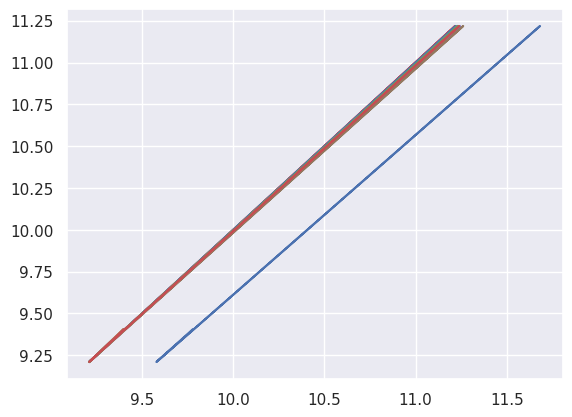

In [8]:
plt.plot(loss_train, loss_val)

Model 1 Shape: (L, B, 10001) (L=40, B=64)  
Model 2 Shape: (L, B, 10001) (L=40, B=64)  
Model 3 Shape: (L, B, 10001) (L=40, B=64)  
Model 4 Shape: (L, B, 10001) (L=40, B=64)  
  
The plot turned out to be linear...  
Since I assume this was not the intended result. It seems there was a problem with either my model implementations, or the transferring of code across notebooks.

<h2>Language Generation</h2>

<div class="alert alert-warning">
    <b>Exercise 4. [30 Points]</b>
    <p>
    Copy the language generation code from the main exercise notebook and perform the following tasks:
    </p>
        <ul>
            <li>Compare all four previous models by generating $12$ words that append the starting word <tt>"despite"</tt>.</li>
            <li>For each model, retrieve the top $10$ wordIDs with the highest probabilities from the generated probability distribution (<code>prob_dist</code>) following the starting word <tt>"despite"</tt>. Fetch the corresponding words of these wordIDs. Do you observe any specific linguistic characteristic common between these words?</li>
            <li>The implementation in the main exercise notebook is based on sampling. Implement a second deterministic variant based on the <i>top-1</i> approach. In this particular variant, the generated word is the word with the highest probability in the predicted probability distribution. Repeat the same procedure as before (i.e., generate $12$ words that append the starting word <tt>"despite"</tt>).</li>
        </ul>
</div>

In [9]:
# your code goes here
for model in model_list:
    print(f"Model {model_list.index(model)}")
    
    GENERATION_LENGTH = 12
    START_WORD = "despite"
    
    start_hidden = None
    START_WORD = START_WORD.lower()
    generated_text = START_WORD
    
    with torch.no_grad():
        wordid_input = dictionary.word2idx[START_WORD]
        for i in range(0, GENERATION_LENGTH):
            data = u6.batchify(torch.tensor([wordid_input]), 1, device)
            
            y_hat_probs, last_hidden = model(data, start_hidden, return_logs=False)
            
            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())
            
            samples = prob_dist.sample((1,10)).numpy()
            sample_words = [dictionary.idx2word[i] for i in samples[0]]
            print(sample_words)
            
            wordid_input = prob_dist.sample()
            word_generated = dictionary.idx2word[wordid_input]
            
            generated_text += " " + word_generated
            
            start_hidden = last_hidden
    
    print(generated_text)

Model 0
['americans', 'warren', 'underwrite', 'enough', 'neutrons', 'weisfield', 'khmer', 'angeles-based', 'palladium', 'minds']
['employ', 'principals', 'instructed', 'pipeline', 'length', 'gm', 'foley', 'sanctions', 'rubicam', 'republic']
['ig', 'doomed', 'hardly', 'turmoil', 'bougainville', 'situations', 'kick', 'oddly', 'orders', 'edt']
['pilot', 'offsetting', 'backdrop', 'pearce', 'rumor', 'door', 'n.v', 'bankruptcy-court', 'difficulty', 'ncnb']
['lackluster', 'predictably', 'deteriorating', 'contribute', 'crushed', 'limit', 'gasoline', 'precious', 'embarrassment', 'corp.']
['resigned', 'situations', 'humor', 'coverage', 'commercial', 'survival', 'collins', 'surprise', 'convention', 'circumstances']
['roadway', 'photo', 'zone', 'shape', 'thereafter', 'tide', 'troubles', 'back', 'records', 'mario']
['shoppers', 'starts', 'calm', 'corruption', 'analytical', 'westmoreland', 'doubtful', 'pa.', 'slowed', 'charlie']
['banque', 'kicked', 'lotus', 'murdoch', 'recreation', 'media', 'forecl

I've noticed that most of the sampled words are either nouns, actions, or characteristics.

In [10]:
for model in model_list:
    print(f"Model {model_list.index(model)}")
    
    GENERATION_LENGTH = 12
    START_WORD = "despite"
    
    start_hidden = None
    START_WORD = START_WORD.lower()
        
    generated_text = START_WORD
    with torch.no_grad():
        wordid_input = dictionary.word2idx[START_WORD]
        for i in range(0, GENERATION_LENGTH):
            data = u6.batchify(torch.tensor([wordid_input]), 1, device)
            
            y_hat_probs, last_hidden = model(data, start_hidden, return_logs=False)
            
            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze()) 
            wordid_input = prob_dist.sample([1])
            word_generated = dictionary.idx2word[wordid_input]
            
            generated_text += " " + word_generated
            
            start_hidden = last_hidden
    
    print(generated_text)

Model 0
despite counsel clinic kong collectors letting highly fundamentally catastrophe secure j.p. tass wear
Model 1
despite shannon adjust manville glass wake j.p. guardian manpower stronger bids staffs appropriate
Model 2
despite paper bank existence wedge norton f-14 hazard reflects hidden limited base installation
Model 3
despite publishers monopoly flows proposition ill. arco stunning tried bribe squeeze pork-barrel drain
